In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,"../")

from src.kernel import TSGaussKernel,TSGaussGaussKernel
from src.loss import VarifoldLoss,SumVarifoldLoss
from src.lddmm import Shooting,Flowing
from src.plotting import plot2Dfigure

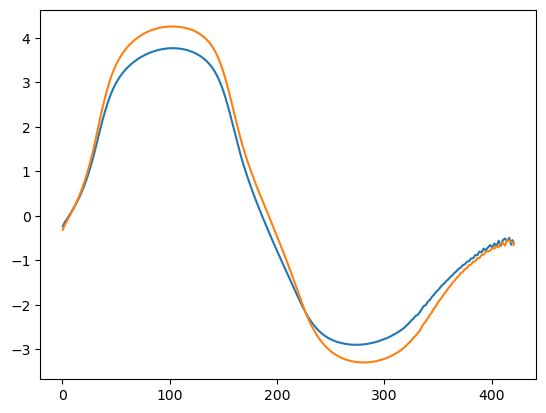

In [2]:
np.random.seed(0)

y =pd.read_csv("./dataset/y_600.csv",index_col=0)
X = np.load("./dataset/X_600.npy")
X_mask = np.load("./dataset/X_600_mask.npy")
idxs = np.load("./results/exp_1_lddmm_0/idxs.npy")
X,X_mask = X[idxs],X_mask[idxs]
X,X_mask = X[:,::2,:],X_mask[:,::2,:]
y = y.iloc[idxs]



p0s = np.load("./results/exp_1_lddmm_0/p0s.npy")
q0 = np.load("./results/exp_1_lddmm_0/q0.npy")
q0_mask = np.load("./results/exp_1_lddmm_0/q0_mask.npy")
p0s = p0s.reshape(-1,p0s.shape[2],p0s.shape[3])
plt.plot(q0[q0_mask.squeeze(),0],q0[q0_mask.squeeze(),1])
plt.plot(q0[q0_mask.squeeze(),0],q0[q0_mask.squeeze(),2])

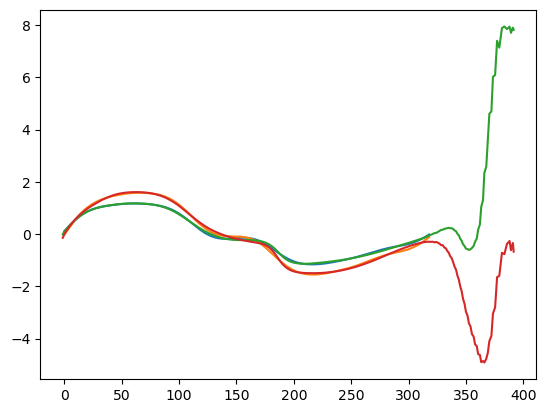

In [3]:
Kv = TSGaussKernel(150,2)
Kl1 = TSGaussGaussKernel(5,2,5,1)
Kl2 = TSGaussGaussKernel(2,1,2,0.6)
Kl3 = TSGaussGaussKernel(1,0.6,1,0.6)
Kls=[Kl1,Kl2,Kl3]
dataloss = SumVarifoldLoss(Kls)

shoot = Shooting(Kv)
flow = Flowing(Kv)

idx = 0
p,q = shoot(p0s[idx],q0,q0_mask)
x = X[idx][X_mask[idx].squeeze()]
qp = q[q0_mask.squeeze()]
plt.plot(x[:,0],x[:,1],)
plt.plot(x[:,0],x[:,2])
plt.plot(qp[:,0],qp[:,1])
plt.plot(qp[:,0],qp[:,2])

In [4]:
from jax import vmap
vshoot = vmap(shoot,(0,None,None),0)
p,q = vshoot(p0s,q0,q0_mask)

vloss = vmap(dataloss,(0,None,0,0))
loss_value = vloss(q,q0_mask,X,X_mask)
print(np.mean(loss_value))

1042.6497


2024-05-21 21:52:47.829207: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.10 = f32[600,600]{1,0} reduce(f32[600,600,3]{2,1,0} %constant.3, f32[] %constant.5), dimensions={2}, to_apply=%region_0.6, metadata={op_name="jit(<lambda>)/jit(main)/reduce_sum[axes=(2,)]" source_file="/home/germain/code/TSLDDMM/mouse/../src/kernel.py" source_line=28}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-05-21 21:52:47.844356: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.015497888s
Constant folding an instruction is taking > 1s:

  %reduce.10 = f32[600,

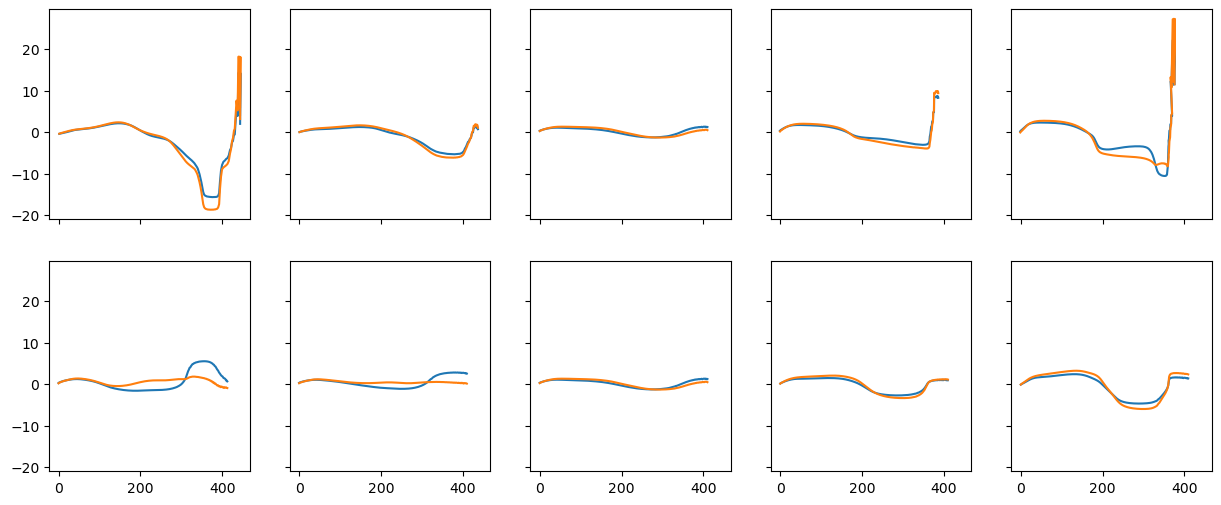

In [17]:
from src.statistic import MomentaPCA
n_comp,n_disp = 2,5
mpca = MomentaPCA(n_comp,False,"cov")
mpca.fit(Kv,p0s,q0,q0_mask)

p0_bar = mpca.m_ps_
plot_mask = np.where(q0_mask==True)[0]
k = 1
shoot = Shooting(Kv)
p0_b = mpca.m_ps_
fig,axs = plt.subplots(n_comp,n_disp,figsize = (n_disp*3,n_comp*3),sharex=True,sharey=True)
for pca_index in range(n_comp):
    sigma_pca = mpca.p_std_[pca_index]
    for j,alpha in enumerate(np.linspace(-3*sigma_pca , 3*sigma_pca, n_disp)):
        p0_mode = p0_b + alpha * mpca.p_pc_[pca_index]
        _,q = shoot(p0_mode,q0,q0_mask)
        plot_q = q[plot_mask].T
        axs[pca_index,j].plot(plot_q[0],plot_q[1])
        axs[pca_index,j].plot(plot_q[0],plot_q[2])

/tmp/ipykernel_1492859/4197659364.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11.442275    6.13283333  3.28498333 10.71610833  0.59155833 10.04145833
  4.060775    8.412425    7.75518333  7.03854167 13.31669167  5.162775
  7.080075    5.52525     6.26725833  3.528825    7.86451667  9.077975
  4.524775    1.68323333 12.11700833  6.48305833  2.2289      0.63905833
 12.49041667  2.11320833  4.30318333  9.91180833  9.61264167  2.634675
 13.61921667  8.31091667  2.64438333 12.53698333 13.2605      5.91893333
  1.79654167  8.30736667  6.08608333  9.14410833 11.16398333  0.27348333
 14.01114167  4.27899167  1.02571667  6.05201667 11.46274167 14.19718333
 11.99968333 10.88709167 14.25390833  0.80569167  6.03240833 12.758525
  5.50325833 11.95425833 12.65255833  3.816025   11.47029167 10.23803333
 10.29786667 15.40724167 14.341325    9.78260833  8.553275    3.80879167
  6.1992     18.92493333  5.614125    1.597875

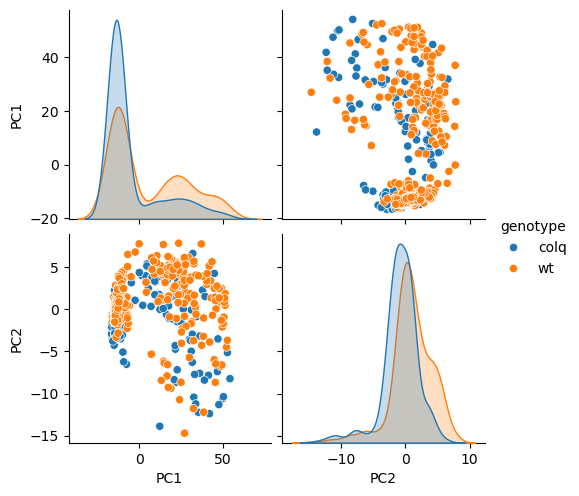

In [18]:
df = y.copy()
filenames = df.filename.unique()

def create_mapping(filenames): 
    dct = {}
    count_colq = 1
    count_wt = 1
    for filename in filenames: 
        if "colq" in filename: 
            dct[filename] = f"colq_{count_colq}"
            count_colq +=1
        elif "wt" in filename: 
            dct[filename] = f"wt_{count_wt}"
            count_wt +=1
    return dct

mapping_dct = create_mapping(filenames)
df["mouse_id"] = df.filename.apply(lambda x :mapping_dct[x])



df[[f"PC{i+1}" for i in range(n_comp)]] = mpca.p_score_
tdf = df[["start","before"]]
max_before = tdf[tdf.before == "Y"].start.max()
tdf.loc[tdf.before == "N","start"] = tdf[tdf.before == "N"].start.copy().values + max_before
tdf.loc[:,"start"] /= (2000.*60.)
df["time"] = tdf.start
sns.pairplot(df,hue = "genotype",vars=[f"PC{i+1}" for i in range(n_comp)])

In [19]:
from scipy.stats import gaussian_kde

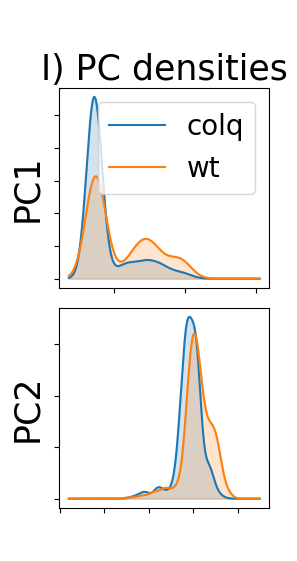

: 

In [39]:
color_mapping ={"colq": "tab:blue", "wt" : "tab:orange"}
components = [f"PC{i+1}" for i in range(n_comp)]
span =0.9
nsample = 10000
ft_size = 25
pft_size = 20



fig,axs = plt.subplots(nrows=n_comp,ncols=1, figsize = (3,n_comp*3))
for i,comp in enumerate(components): 
    r = df[comp].values.max()
    l = df[comp].values.min()
    x = np.linspace(l -np.abs(span*l),r +np.abs(span*r),nsample)
    for gen,color in color_mapping.items(): 
        arr = df[df.genotype == gen][comp].values
        y = gaussian_kde(arr)(x)
        axs[i].plot(x,y,color=color,label=gen)
        axs[i].fill_between(x,y,color=color,alpha=0.2)
        axs[i].set_ylabel(comp,fontsize=ft_size)


for ax in axs: 
    ax.set_yticklabels([])
    ax.set_xticklabels([])
axs[0].legend(fontsize=pft_size)
axs[0].set_title("I) PC densities",fontsize=ft_size)
axs[-1].set_xlabel(" ",fontsize=pft_size)
fig.suptitle(" ",fontsize=ft_size)


plt.subplots_adjust(left=0.2,bottom=0.15,right=0.9,top=0.85,wspace=0.1,hspace=0.1)
fig.savefig("./exp_1_lddmm_density.jpeg",format="jpeg")

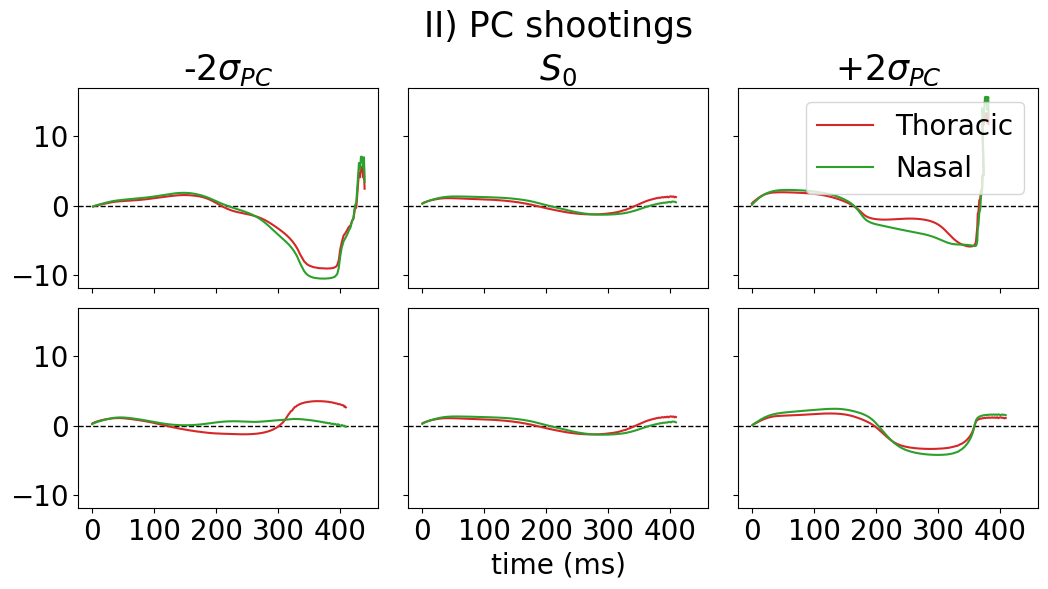

In [38]:
from src.statistic import MomentaPCA
ncomp,ndisp = 2,3
mpca = MomentaPCA(ncomp)
mpca.fit(Kv,p0s,q0,q0_mask)

p0_bar = mpca.m_ps_
k = 1

fig,axs = plt.subplots(ncomp,ndisp,figsize = (ndisp*4,ncomp*3),sharex=True,sharey=True)
for pca_index in range(ncomp):
    sigma_pca = np.std(mpca.p_score_[:,pca_index])
    for j,alpha in enumerate(np.linspace(-2*sigma_pca , 2*sigma_pca, ndisp)):
        p0_mode = p0_bar + alpha * mpca.p_pc_[pca_index]
        p,q = shoot(p0_mode,q0,q0_mask)
        q = q[q0_mask.squeeze()]
        axs[pca_index,j].plot(q[:,0],q[:,1],color="tab:red",label="Thoracic")
        axs[pca_index,j].plot(q[:,0],q[:,2],color="tab:green",label="Nasal")
        k += 1

for ax in axs.flatten():
    ax.axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

axs[-1,1].set_xlabel("time (ms)",fontsize=pft_size)

axs[0,0].set_title(r"-2$\sigma_{PC}$",fontsize=ft_size)
axs[0,1].set_title(r"$S_0$",fontsize=ft_size)
axs[0,2].set_title(r"+2$\sigma_{PC}$",fontsize=ft_size)
axs[0,2].legend(fontsize = pft_size,loc=1)
for ax in axs[-1,:]:
    ax.xaxis.set_tick_params(labelsize=pft_size)
for ax in axs[:,0]:
    ax.yaxis.set_tick_params(labelsize=pft_size)

fig.suptitle("II) PC shootings",fontsize = ft_size)

plt.subplots_adjust(left=0.1,bottom=0.15,right=0.9,top=0.85,wspace=0.1,hspace=0.1)
fig.savefig("./exp_1_lddmm_shooting.jpeg",format="jpeg")


In [ ]:
idxs

array([ 3256,  3408,  3345,  3336,  3415,  3420,  3243,  3384,  3250,
        3390,  3299,  3363,  3418,  3392,  3318,  3245,  3271,  3368,
        3275,  3312,  3421,  3383,  3283,  3397,  3298,  3361,  3417,
        3423,  3360,  3282,  3254,  3293,  3388,  3349,  3260,  3427,
        3367,  3242,  3321,  3344,  3372,  3304,  3264,  3351,  3406,
        3301,  3246,  3313,  3356,  3381,  3820,  3723,  3766,  3787,
        3784,  3714,  3762,  3772,  3801,  3785,  3815,  3745,  3790,
        3842,  3755,  3764,  3813,  3794,  3837,  3746,  3832,  3773,
        3734,  3828,  3786,  3728,  3760,  3722,  3826,  3808,  3804,
        3712,  3765,  3850,  3806,  3763,  3721,  3802,  3715,  3824,
        3727,  3768,  3835,  3791,  3767,  3803,  3829,  3856,  3823,
        3797,  4202,  4327,  4382,  4252,  4322,  4311,  4372,  4284,
        4265,  4213,  4207,  4336,  4331,  4376,  4225,  4240,  4290,
        4263,  4283,  4313,  4356,  4334,  4350,  4249,  4199,  4198,
        4333,  4326,

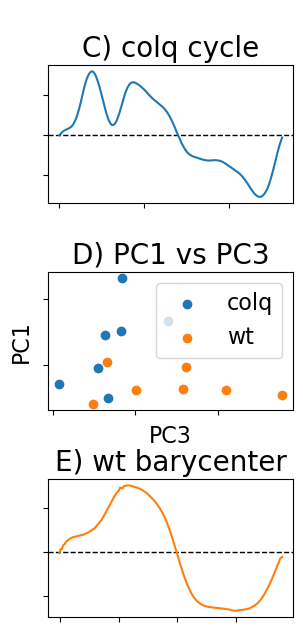

In [ ]:
fig,axs = plt.subplots(nrows=ncomp,ncols=1, figsize = (3.5,ncomp*2.3))

idxs = np.argsort(df.PC1.values)[::-1]
idx = idxs[154]
q = X[idx]
q_mask = X_mask[idx]
axs[0].set_title("C) colq cycle",fontsize =ft_size)
axs[0].plot(*q[q_mask.squeeze()].T,color = color_mapping["colq"])
axs[0].axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

axs[1].set_title("D) PC1 vs PC3",fontsize =ft_size)
c = pdf[pdf.genotype == "colq"][["PC3","PC1"]].values
axs[1].scatter(*c.T,color=color_mapping["colq"],label="colq")
w = pdf[pdf.genotype == "wt"][["PC3","PC1"]].values
axs[1].scatter(*w.T,color = color_mapping["wt"],label="wt")
axs[1].set_xlabel("PC3", fontsize=pft_size)
axs[1].set_ylabel("PC1", fontsize=pft_size)

axs[2].set_title("E) wt barycenter",fontsize =ft_size)
idx = pdf.PC3.argmax()
axs[2].plot(*qs[idx][qs_mask[idx].squeeze()].T,color= color_mapping["wt"])
axs[2].axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

axs[1].legend(fontsize=pft_size)
fig.suptitle(" ",fontsize=ft_size)
plt.subplots_adjust(left=0.2,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.5)

fig.savefig("./exp_1_exemple.jpeg",format="jpeg")
